In [149]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
import getpass
import os
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from pydantic import BaseModel
from typing import Literal
import functools
import operator
from typing import Sequence, TypedDict
import json
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

from langchain_community.tools.tavily_search import TavilySearchResults
llm = ChatGroq(model="mixtral-8x7b-32768")
load_dotenv()

True

In [76]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GROQ_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


In [77]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'\n{doc.page_content}\n'
            for doc in docs
        ]
    )

In [78]:
#Create a worker agent.
#Create a supervisor for the sub-graph.

from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [79]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str



search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

In [80]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

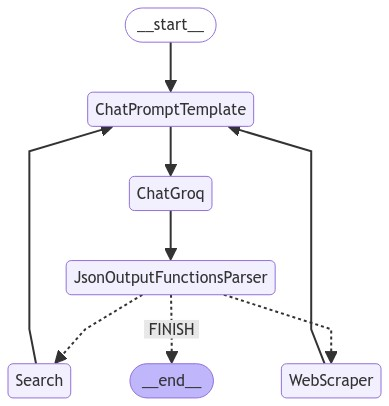

In [81]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

Chat-bot code



In [124]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GROQ_API_KEY") 
_set_if_undefined("LANGCHAIN_API_KEY") 
_set_if_undefined("TAVILY_API_KEY") 

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

Search Tool: TavilySearchResults is initialized to provide a search tool that returns a maximum of 5 results.
Python REPL Tool: PythonREPLTool is initialized to allow Python code execution within the agent's environment.

In [125]:
tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

Define Agent Creation: create_agent is a function that takes a language model (llm), a list of tools, and a system prompt to create an AI agent.
Prompt Template: Uses ChatPromptTemplate to define the conversation's initial state and placeholders for future messages.
Agent and Executor: Creates an OpenAI tool agent with the defined tools and prompt, then wraps it in an AgentExecutor for easy execution.

In [126]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
#from langchain.output_parsers import JsonOutputFunctionsParser

llm = ChatGroq(model="llama-3.1-70b-versatile") 


def create_agent(llm: ChatGroq, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

Define Node Behavior: agent_node is a function that takes a state, agent, and name, invokes the agent with the state, and returns the output as a HumanMessag

In [127]:
def agent_node(state, agent, name):
    print("-------------------")
    print(state)
    print("----------------------------")
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

State Definition: AgentState is a TypedDict that defines the structure of the state, including a sequence of messages and the next step.

In [138]:
# Define the AgentState TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]  # Using operator.add for message accumulation
    next: str

# Define the members of the conversation
# members = [ 
#     "Sales_Agent",
#     "Product_Search_Agent",
#     "Stock_Check_Agent",
#     "Price_Check_Agent",
#     "Order_Handling_Agent",
#     "Order_Status_Agent",
#     "Delivery_Status_Agent"
# ]

#llm = ChatGroq(model="mixtral-8x7b-32768")  
members = ["Sales_Agent", "Order_Handling_Agent"]
sales_members = ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent"]
orderhandling_members = ["Order_Status_Agent", "Delivery_Status_Agent"]

#options = ["FINISH"] +  members   #+ sales_members + orderhandling_members

# Define Routing Function: function_def is a dictionary that describes a function called "route," which is responsible for selecting the next agent role.
# function_def = {
#     "name": "route",
#     "description": "Select the next role.",
#     "parameters": {
#         "title": "routeSchema",
#         "type": "object",
#         "properties": {
#             "next": {
#                 "title": "Next",
#                 "anyOf": [
#                     {"enum": options},
#                 ],
#             }
#         },
#         "required": ["next"],
#     },
# }

options = ["FINISH"] + members + sales_members + orderhandling_members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "enum": options,  
            }
        },
        "required": ["next"],
    },
}


# Global Supervisor Prompt

# global_system_prompt = """
# You are a supervisor working with multiple workers to resolve a customer's issue.
# Read the conversation history and understand the user's query. 
# Then pick the best suited agent to resolve the issue.

# List of workers available:
# "sales" : handles sales related queries, for example, intent to buy products, find relevant products, check available stock or check the price.
# "order_manager" : handles placing the order and checks the status of previously placed orders.

# If the user query has been resolved, reply with "finished".

# Make sure your final response is a valid json object in the following format:
# {
#     "next": "sales" or "order_Agent" or ""FINISHED""
# }

# Your final response should not contain any other text, explanation, or comments than the needed json object.
# """



global_system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f"following workers: {', '.join(members)}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " If the user query has been resolved, reply with 'FINISHED'."
)

# Sales Agent Supervisor Prompt
sales_agent_prompt = (
    "You are the Sales Agent Supervisor. Route the conversation to the appropriate"
    f"following workers: {', '.join(sales_members)}."
    " agent for handling product search, then price check, and then stock check."
    " When all tasks are completed, select FINISH."
)

# Order Handling Agent Supervisor Prompt
order_handling_prompt = (
    "You are the Order Handling Supervisor. Route the conversation to the appropriate"
    f"following workers: {', '.join(orderhandling_members)}."
    " agent for handling orders, checking order status, or checking delivery status."
    " When all tasks are completed, select FINISH."
)

# Create ChatPromptTemplates
global_system_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", global_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Select the next members. Options: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

sales_agent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", sales_agent_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Select the next agent like sales_members for sales-related tasks. Options: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(sales_members),)

order_handling_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", order_handling_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Select the next agent like orderhandling_members for order-related tasks. Options: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(orderhandling_members))

# Initialize the LLM
#llm = ChatGroq(model="llama3-8b-8192")
#llm = ChatGroq(model="mixtral-8x7b-32768") 
#llm = ChatGroq(model="llama-3.1-70b-versatile")  
#"llama-3.1-70b-versatile"

# Define the supervisor chains
# global_supervisor_chain = (
#     global_system_prompt
#     | llm.bind_functions(functions=[function_def], function_call="route")
#     | JsonOutputFunctionsParser()
    
# )

# sales_agent_chain = (
#     sales_agent_prompt
#     | llm.bind_functions(functions=[function_def], function_call="route")
#     | JsonOutputFunctionsParser()
#     | global_supervisor_chain
# )

# order_handling_chain = (
#     order_handling_prompt
#     | llm.bind_functions(functions=[function_def], function_call="route")
#     | JsonOutputFunctionsParser()
#     | global_supervisor_chain
# )

global_supervisor_chain = (
    global_system_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

sales_agent_chain = (
    sales_agent_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

order_handling_chain = (
    order_handling_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


In [143]:
# Define the individual agents
# customer_interaction = create_agent(llm, [tavily_tool], "You handle customer inquiries and interactions.")
sales_agent = create_agent(llm, [tavily_tool], "You act as a sales agent, managing product and sales queries, required prices also.")
product_search_agent = create_agent(llm, [tavily_tool], "You search for products based on customer requests.")
stock_check_agent = create_agent(llm, [tavily_tool], "You check stock availability.")
price_check_agent = create_agent(llm, [tavily_tool], "You check the prices of products.")
order_handling_agent = create_agent(llm, [tavily_tool], "You handle orders, from entry to processing, when clicked to cart or selected to buy.")
order_status_agent = create_agent(llm, [tavily_tool], "You check the status of customer orders, when placed the order only.")
delivery_status_agent = create_agent(llm, [tavily_tool], "You check the delivery status of orders once the order is booked only.")

# Create partial functions for each agent node
# customer_interaction_node = functools.partial(agent_node, agent=customer_interaction, name="Customer Interaction")
# sales_agent_node = functools.partial(agent_node, agent=sales_agent, name="Sales_Agent")
product_search_agent_node = functools.partial(agent_node, agent=product_search_agent, name="Product_Search_Agent")
stock_check_agent_node = functools.partial(agent_node, agent=stock_check_agent, name="Stock_Check_Agent")
price_check_agent_node = functools.partial(agent_node, agent=price_check_agent, name="Price_Check_Agent")
# order_handling_agent_node = functools.partial(agent_node, agent=order_handling_agent, name="Order_Handling_Agent")
order_status_agent_node = functools.partial(agent_node, agent=order_status_agent, name="Order_Status_Agent")
delivery_status_agent_node = functools.partial(agent_node, agent=delivery_status_agent, name="Delivery_Status_Agent")


workflow = StateGraph(AgentState)


workflow.add_node("Supervisor", global_supervisor_chain)

workflow.add_node("Sales_Agent", sales_agent_chain)
workflow.add_node("Product_Search_Agent", product_search_agent_node)
workflow.add_node("Stock_Check_Agent", stock_check_agent_node)
workflow.add_node("Price_Check_Agent", price_check_agent_node)
workflow.add_node("Order_Handling_Agent", order_handling_chain)
workflow.add_node("Order_Status_Agent", order_status_agent_node)
workflow.add_node("Delivery_Status_Agent", delivery_status_agent_node)


#code  ksz

# workflow.add_node("Product_Search_Agent", "Sales_Agent")
# workflow.add_node("Stock_Check_Agent", "Sales_Agent")
# workflow.add_node("Price_Check_Agent", "Sales_Agent")
# #workflow.add_edge("NodeA", "NodeB")

# workflow.add_node("Order_Status_Agent", "Order_Handling_Agent")
# workflow.add_node("Delivery_Status_Agent", "Order_Handling_Agent")

#workflow.add_node("End", Order_Handling_Agent)


workflow.add_edge(START, "Supervisor")


members_Array = ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent", "Order_Status_Agent", "Delivery_Status_Agent"]
#sub_supervisors_Array = ["Sales_Agent", "Order_Handling_Agent"]


#supervisors_Array = sub_supervisors_Array + ["Supervisor"]

#Add edges to ensure agents report back to their respective supervisors
# for member in members:
#     # Determine which sub-supervisor the agent should report back to
#     if member in ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent"]:
#         workflow.add_edge(member, "Sales_Agent")
#     elif member in ["Order_Status_Agent", "Delivery_Status_Agent"]:
#         workflow.add_edge(member, "Order_Handling_Agent")



# for member in members_Array:
#     # Determine which sub-supervisor the agent should report back to
#     if member in ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent"]:
#         workflow.add_edge(member, "Sales_Agent")
#     elif member in ["Order_Status_Agent", "Delivery_Status_Agent"]:
#         workflow.add_edge(member, "Order_Handling_Agent")



conditional_map = {
    "Sales_Agent": "Sales_Agent",
    "Order_Handling_Agent": "Order_Handling_Agent",
    "FINISH": END
}
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

sales_conditional_map = {
    "Product_Search_Agent": "Product_Search_Agent",
    "Price_Check_Agent": "Price_Check_Agent",
    "Stock_Check_Agent": "Stock_Check_Agent",
    "FINISH": "Supervisor"
}
workflow.add_conditional_edges("Sales_Agent", lambda x: x["next"], sales_conditional_map)



order_conditional_map = {
    "Order_Status_Agent": "Order_Status_Agent",
    "Delivery_Status_Agent": "Delivery_Status_Agent",
    "FINISH": "Supervisor"
}
workflow.add_conditional_edges("Order_Handling_Agent", lambda x: x["next"], order_conditional_map)


# conditional_map = {member: member for member in members + sales_members + orderhandling_members}
# conditional_map["FINISH"] = END
# workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

# sales_conditional_map = {member: member for member in sales_members}
# sales_conditional_map["FINISH"] = "Supervisor"
# workflow.add_conditional_edges("Sales_Agent", lambda x: x["next"], sales_conditional_map)

# order_conditional_map = {member: member for member in orderhandling_members}
# order_conditional_map["FINISH"] = "Supervisor"
# workflow.add_conditional_edges("Order_Handling_Agent", lambda x: x["next"], order_conditional_map)

for member in members_Array:
    # Determine which sub-supervisor the agent should report back to
    if member in ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent"]:
        workflow.add_edge(member, "Sales_Agent")
    elif member in ["Order_Status_Agent", "Delivery_Status_Agent"]:
        workflow.add_edge(member, "Order_Handling_Agent")

graph = workflow.compile()

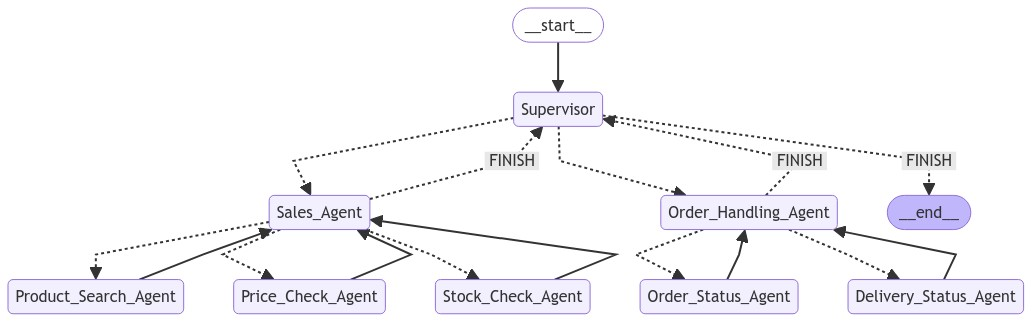

In [144]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [145]:
from langchain_core.messages import BaseMessage, HumanMessage

# The input message to be processed by the graph

# user_message = "I want to buy laptop"
# input_message = {
#     "messages": [
#         HumanMessage(content=user_message)
#     ]
# }
# # Stream the output from the graph and print the results
# for state in graph.stream(input_message):
#     print(f"Current State: {state}")
#     if "__end__" not in state:
#         print(state)
#         print("----")

input_message = {
    "messages": [
        HumanMessage(content="I want to buy a laptop")
    ]
}

try:
    for state in graph.stream(input_message):
        print(f"Current State: {state}")
        if "__end__" not in state:
            print(state)
            print("----")
except Exception as e:
    print(f"An error occurred: {str(e)}")



Current State: {'Supervisor': {'next': 'Sales_Agent'}}
{'Supervisor': {'next': 'Sales_Agent'}}
----
Current State: {'Sales_Agent': {'next': 'Product_Search_Agent'}}
{'Sales_Agent': {'next': 'Product_Search_Agent'}}
----
-------------------
{'messages': [HumanMessage(content='I want to buy a laptop')], 'next': 'Product_Search_Agent'}
----------------------------
Current State: {'Product_Search_Agent': {'messages': [HumanMessage(content="Based on the search results, here are some of the best laptops to buy now:\n\n1. Lenovo Yoga 9i Gen 8 - Best Convertible 2-in-1 Laptop\n2. Lenovo ThinkPad X1 Carbon Gen 11 (2023) - Best Business Laptop\n3. Dell Precision 5680 - Best Workstation Laptop\n4. Apple MacBook Air 13 (M2, 2023) - Best Upper Mid-Range Laptop\n5. HP Spectre x360 13.5 - Best 13-inch Laptop\n6. Acer Swift Edge 16 - Best 16-inch Laptop\n7. LG Gram 17 - Best 17-inch Laptop\n8. Acer Chromebook Plus 515 - Best Value Laptop\n9. Asus Zenbook 14 - Best Under $1,000 Laptop\n10. Dell XPS 15 

In [146]:
input_message = {
    "messages": [
        HumanMessage(content="I want to buy 10 Apple laptop, place the order to delhi")
    ]
}

try:
    for state in graph.stream(input_message):
        print(f"Current State: {state}")
        if "__end__" not in state:
            print(state)
            print("----")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Current State: {'Supervisor': {'next': 'Sales_Agent'}}
{'Supervisor': {'next': 'Sales_Agent'}}
----
Current State: {'Sales_Agent': {'next': 'Product_Search_Agent'}}
{'Sales_Agent': {'next': 'Product_Search_Agent'}}
----
-------------------
{'messages': [HumanMessage(content='I want to buy 10 Apple laptop, place the order to delhi')], 'next': 'Product_Search_Agent'}
----------------------------
Current State: {'Product_Search_Agent': {'messages': [HumanMessage(content="Based on the search results, it appears that there are several options for buying Apple laptops in Delhi. Here are a few options:\n\n1. iFuture Apple Store Authorised Reseller - Karol Bagh, Delhi: This store offers a range of Apple products, including MacBooks, and has a customer support number and directions to the store.\n2. Myimagine Store - New Delhi: This store is an authorized Apple reseller and offers a range of Apple products, including MacBooks.\n3. Nehru Place Dealers - New Delhi: This website lists several deal

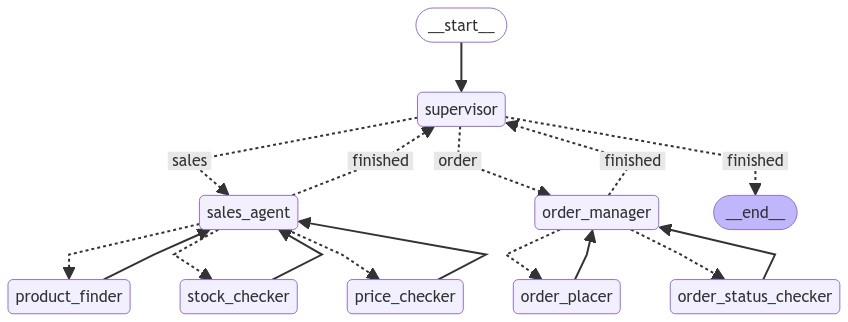

[-2:checkpoint] State at the end of step -2:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [('system',
               '\n'
               'You are a supervisor working with multiple workers to resolve '
               "a customer's issue.\n"
               "Read the conversation history and understand the user's "
               'query. \n'
               'Then pick the best suited agent to resolve the issue.\n'
               '\n'
               'List of workers available:\n'
               '"sales" : handles sales related queries, for example, intent '
               'to buy products, find relevant products, check available stock '
               'or check the price.\n'
               '"order_manager" : handles placing the order and checks the '
               'status of previously placed orders.\n'
               '\n'
               'If the user query has been resolved, reply with "finished".\n'
               '\n'
               'Make sure your

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [142]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from typing import Annotated, Literal, Dict, Union, TypedDict, List, Any, Optional
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from langchain_core.output_parsers import JsonOutputParser

supervisor_system_prompt = """
You are a supervisor working with multiple workers to resolve a customer's issue.
Read the conversation history and understand the user's query. 
Then pick the best suited agent to resolve the issue.

List of workers available:
"sales" : handles sales related queries, for example, intent to buy products, find relevant products, check available stock or check the price.
"order_manager" : handles placing the order and checks the status of previously placed orders.

If the user query has been resolved, reply with "finished".

Make sure your final response is a valid json object in the following format:
{
    "next": "sales" or "order_manager" or "finished"
}

Your final response should not contain any other text, explanation, or comments than the needed json object.
"""

llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
)

class SupervisorResponse(BaseModel):
    next: Literal["sales", "order_manager", "finished"]

class ExampleState(BaseModel):
    messages: List[BaseMessage]
    query: str
    sales_agent_next_agent: Optional[str]
    supervisor_next_agent: Optional[str]
    order_manager_next_agent: Optional[str]


workflow = StateGraph(ExampleState)


def supervisor(state: ExampleState):
    # CALL LLM and decide the next agent
    agent = create_react_agent(
        llm,
        tools=[],
        debug=True,
    )
    messages = [("system", supervisor_system_prompt,), ("user", state.query)]
    res = agent.invoke(input={"messages": messages})
    parser = JsonOutputParser(pydantic_object=SupervisorResponse)
    parsed_res = parser.parse(res["messages"][-1].content)
    state.supervisor_next_agent = parsed_res["next"]
    return state


def sales_agent(state: ExampleState):
     # CALL LLM and decide the next agent
    state.sales_agent_next_agent = "finished"
    return state


def order_manager(state: ExampleState):
    return state


def price_checker(state: ExampleState):
    return state


def product_finder(state: ExampleState):
    return state


def stock_checker(state: ExampleState):
    return state


def order_placer(state: ExampleState):
    return state


def order_status_checker(state: ExampleState):
    return state


def decide_supervisor_path(state: ExampleState):
    if state.supervisor_next_agent == "sales":
        return "sales"
    elif state.supervisor_next_agent == "order":
        return "order"
    else:
        return "finished"


def decide_sales_agent_path(state: ExampleState):
    if state.sales_agent_next_agent == "product_finder":
        return "product_finder"
    elif state.sales_agent_next_agent == "stock_checker":
        return "stock_checker"
    elif state.sales_agent_next_agent == "price_checker":
        return "price_checker"
    else:
        return "finished"


def decide_order_manager_path(state: ExampleState):
    if state.order_manager_next_agent == "order_placer":
        return "order_placer"
    elif state.order_manager_next_agent == "order_status_checker":
        return "order_status_checker"
    else:
        return "finished"

workflow.add_node("supervisor", supervisor)
workflow.add_node("sales_agent", sales_agent)
workflow.add_node("order_manager", order_manager)
workflow.add_node("price_checker", price_checker)
workflow.add_node("product_finder", product_finder)
workflow.add_node("stock_checker", stock_checker)
workflow.add_node("order_placer", order_placer)
workflow.add_node("order_status_checker", order_status_checker)

workflow.add_edge(START, "supervisor")  # => sales_agent , order_manager, END
workflow.add_conditional_edges(
    "supervisor",
    decide_supervisor_path,
    {
        "sales": "sales_agent",
        "order": "order_manager",
        "finished": END,
    },
)

workflow.add_conditional_edges(
    "sales_agent",
    decide_sales_agent_path,
    {
        "product_finder": "product_finder",
        "stock_checker": "stock_checker",
        "price_checker": "price_checker",
        "finished": "supervisor",
    },
)

workflow.add_edge("product_finder", "sales_agent")
workflow.add_edge("stock_checker", "sales_agent")
workflow.add_edge("price_checker", "sales_agent")



workflow.add_conditional_edges(
    "order_manager",
    decide_order_manager_path,
    {
        "order_placer": "order_placer",
        "order_status_checker": "order_status_checker",
        "finished": "supervisor",
    },
)

workflow.add_edge("order_placer", "order_manager")
workflow.add_edge("order_status_checker", "order_manager")

compiled_workflow = workflow.compile()

display(
    Image(
        compiled_workflow.get_graph(xray=1).draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

compiled_workflow.invoke(
    ExampleState(
        messages=[HumanMessage(content="I want to buy a laptop")],
        query="I want to buy a laptop",
    )
)